In [4]:
import networkx as nx
import random

# Constants
# BC population in 2021:
num_nodes = 3327824
# 53 cities in BC
num_communities = 53
# Population density of BC cities
bc_population_density = [
    {"name": "Abbotsford", "population": 15352, "density": 2},
    {"name": "Armstrong", "population": 532, "density": 3},
    {"name": "Burnaby", "population": 24912, "density": 6},
    {"name": "Campbell River", "population": 3551, "density": 1},
    {"name": "Castlegar", "population": 833, "density": 2},
    {"name": "Chilliwack", "population": 9320, "density": 2},
    {"name": "Colwood", "population": 1896, "density": 3},
    {"name": "Coquitlam", "population": 14862, "density": 3},
    {"name": "Courtenay", "population": 2842, "density": 2},
    {"name": "Cranbrook", "population": 2049, "density": 2},
    {"name": "Dawson Creek", "population": 1232, "density": 2},
    {"name": "Delta", "population": 10845, "density": 2},
    {"name": "Duncan", "population": 504, "density": 5},
    {"name": "Enderby", "population": 302, "density": 2},
    {"name": "Fernie", "population": 632, "density": 2},
    {"name": "Fort St. John", "population": 2146, "density": 2},
    {"name": "Grand Forks", "population": 411, "density": 2},
    {"name": "Greenwood", "population": 70, "density": 1},
    {"name": "Kamloops", "population": 9790, "density": 2},
    {"name": "Kelowna", "population": 14457, "density": 2},
    {"name": "Kimberley", "population": 811, "density": 1},
    {"name": "Langford", "population": 4658, "density": 3},
    {"name": "Langley", "population": 2896, "density": 6},
    {"name": "Maple Ridge", "population": 9099, "density": 2},
    {"name": "Merritt", "population": 705, "density": 1},
    {"name": "Mission", "population": 4151, "density": 1},
    {"name": "Nanaimo", "population": 9986, "density": 3},
    {"name": "Nelson", "population": 1110, "density": 3},
    {"name": "New Westminster", "population": 7891, "density": 9},
    {"name": "North Vancouver", "population": 5812, "density": 9},
    {"name": "Parksville", "population": 1364, "density": 3},
    {"name": "Penticton", "population": 3688, "density": 2},
    {"name": "Pitt Meadows", "population": 1914, "density": 1},
    {"name": "Port Alberni", "population": 1825, "density": 3},
    {"name": "Port Coquitlam", "population": 6149, "density": 4},
    {"name": "Port Moody", "population": 3353, "density": 3},
    {"name": "Powell River", "population": 1394, "density": 2},
    {"name": "Prince George", "population": 7670, "density": 1},
    {"name": "Prince Rupert", "population": 1230, "density": 1},
    {"name": "Quesnel", "population": 988, "density": 1},
    {"name": "Revelstoke", "population": 827, "density": 1},
    {"name": "Richmond", "population": 20993, "density": 4},
    {"name": "Rossland", "population": 414, "density": 1},
    {"name": "Salmon Arm", "population": 1943, "density": 1},
    {"name": "Surrey", "population": 56832, "density": 4},
    {"name": "Terrace", "population": 1201, "density": 1},
    {"name": "Trail", "population": 792, "density": 1},
    {"name": "Vancouver", "population": 66224, "density": 11},
    {"name": "Vernon", "population": 4451, "density": 2},
    {"name": "Victoria", "population": 9186, "density": 9},
    {"name": "West Kelowna", "population": 3607, "density": 1},
    {"name": "White Rock", "population": 2193, "density": 8},
    {"name": "Williams Lake", "population": 1094, "density": 2}
]


# City-specific parameters
community_sizes = [num_nodes // num_communities] * num_communities
community_graphs = [
    nx.barabasi_albert_graph(each_city["population"], each_city["density"]) for each_city in bc_population_density]


# Combine regions into a single graph with inter-regional connections
G = nx.Graph()
offset = 0
for idx, community in enumerate(community_graphs):
    # Renumber nodes to prevent conflicts
    mapping = {node: node + offset for node in community.nodes}
    community = nx.relabel_nodes(community, mapping)
    G = nx.compose(G, community)
    offset += community.number_of_nodes()

    # Inter-region connections
    if idx < num_communities - 1:
        for _ in range(1145):  # Randomly connect 50 edges between regions
            node_a = random.choice(list(community.nodes))
            node_b = random.choice(list(community_graphs[idx + 1].nodes)) + offset
            G.add_edge(node_a, node_b)

# Initialize Infection Status
status = {node: 'S' for node in G.nodes}
initial_infected = random.sample(list(G.nodes), 20)  # Initial infections
for node in initial_infected:
    status[node] = 'E'

# COVID-19 Simulation Parameters
infection_rate = 0.15  # Initial infection rate
recovery_rate = 0.9
mortality_rate = 0.01
incubation_period = 5  # Days before symptoms
mutation_weeks = [48,96]  # Weeks when virus mutates

# Weekly Reporting
weekly_data = {'new_cases': [], 'cumulative_cases': [], 'deaths': []}
exposed_duration = {node: 0 for node in G.nodes}
cumulative_cases = len(initial_infected)

def simulate_week(status, exposed_duration):
    global infection_rate, cumulative_cases
    new_cases = 0
    deaths = 0

    for _ in range(7):  # Simulate 7 days per week
        new_status = status.copy()

        for node in G.nodes:
            if status[node] == 'E':
                exposed_duration[node] += 1
                if exposed_duration[node] >= incubation_period:
                    new_status[node] = 'I'
                    new_cases += 1

            elif status[node] == 'I':
                # Infect neighbors
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and random.random() < infection_rate:
                        new_status[neighbor] = 'E'

                # Death or Recovery
                if random.random() < mortality_rate:
                    new_status[node] = 'D'
                    deaths += 1
                elif random.random() < recovery_rate:
                    new_status[node] = 'R'

        status = new_status

    # Mutation Effect
    current_week = len(weekly_data['new_cases'])
    if current_week in mutation_weeks:
        infection_rate *= 1.2  # Increase infection rate by 20% for mutations

    cumulative_cases += new_cases
    weekly_data['new_cases'].append(new_cases)
    weekly_data['cumulative_cases'].append(cumulative_cases)
    weekly_data['deaths'].append(deaths)

    return status

# Simulate over 12 weeks
weeks = 200
status_history = [status]
for week in range(weeks):
    status = simulate_week(status, exposed_duration)
    status_history.append(status)

# Print Weekly Report
print("Weekly Report:")
for week in range(weeks):
    print(f"Week {week + 1}: New Cases = {weekly_data['new_cases'][week]}, "
          f"Cumulative Cases = {weekly_data['cumulative_cases'][week]}, "
          f"Deaths = {weekly_data['deaths'][week]}")


Weekly Report:
Week 1: New Cases = 20, Cumulative Cases = 40, Deaths = 0
Week 2: New Cases = 29, Cumulative Cases = 69, Deaths = 1
Week 3: New Cases = 192, Cumulative Cases = 261, Deaths = 4
Week 4: New Cases = 1311, Cumulative Cases = 1572, Deaths = 11
Week 5: New Cases = 30124, Cumulative Cases = 31696, Deaths = 84
Week 6: New Cases = 36435, Cumulative Cases = 68131, Deaths = 538
Week 7: New Cases = 15362, Cumulative Cases = 83493, Deaths = 257
Week 8: New Cases = 7388, Cumulative Cases = 90881, Deaths = 85
Week 9: New Cases = 4517, Cumulative Cases = 95398, Deaths = 56
Week 10: New Cases = 3059, Cumulative Cases = 98457, Deaths = 30
Week 11: New Cases = 6057, Cumulative Cases = 104514, Deaths = 39
Week 12: New Cases = 3657, Cumulative Cases = 108171, Deaths = 55
Week 13: New Cases = 3650, Cumulative Cases = 111821, Deaths = 47
Week 14: New Cases = 5152, Cumulative Cases = 116973, Deaths = 57
Week 15: New Cases = 6802, Cumulative Cases = 123775, Deaths = 76
Week 16: New Cases = 6994,

# Similar code, that generate line graph

Weekly Report:
Week 1: New Cases = 20, Cumulative Cases = 40, Deaths = 1
Week 2: New Cases = 30, Cumulative Cases = 70, Deaths = 2
Week 3: New Cases = 185, Cumulative Cases = 255, Deaths = 2
Week 4: New Cases = 1124, Cumulative Cases = 1379, Deaths = 13
Week 5: New Cases = 26265, Cumulative Cases = 27644, Deaths = 72
Week 6: New Cases = 34951, Cumulative Cases = 62595, Deaths = 534
Week 7: New Cases = 20976, Cumulative Cases = 83571, Deaths = 307
Week 8: New Cases = 14419, Cumulative Cases = 97990, Deaths = 180
Week 9: New Cases = 10450, Cumulative Cases = 108440, Deaths = 116
Week 10: New Cases = 8118, Cumulative Cases = 116558, Deaths = 81
Week 11: New Cases = 6339, Cumulative Cases = 122897, Deaths = 35
Week 12: New Cases = 4490, Cumulative Cases = 127387, Deaths = 55
Week 13: New Cases = 3689, Cumulative Cases = 131076, Deaths = 58
Week 14: New Cases = 2424, Cumulative Cases = 133500, Deaths = 26
Week 15: New Cases = 1801, Cumulative Cases = 135301, Deaths = 28
Week 16: New Cases =

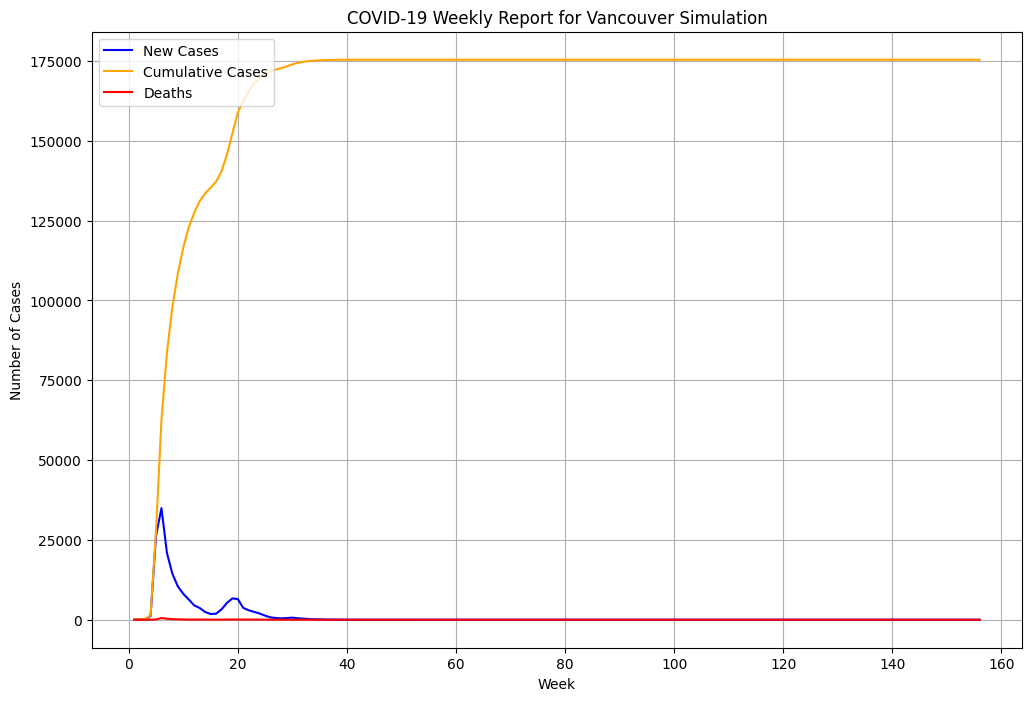

In [5]:
import networkx as nx
import random
import matplotlib.pyplot as plt


# Constants for BC
# BC population in 2021:
num_nodes = 3327824
# 53 cities in BC
num_communities = 53
# Population density of BC cities
bc_population_density = [
    {"name": "Abbotsford", "population": 15352, "density": 2},
    {"name": "Armstrong", "population": 532, "density": 3},
    {"name": "Burnaby", "population": 24912, "density": 6},
    {"name": "Campbell River", "population": 3551, "density": 1},
    {"name": "Castlegar", "population": 833, "density": 2},
    {"name": "Chilliwack", "population": 9320, "density": 2},
    {"name": "Colwood", "population": 1896, "density": 3},
    {"name": "Coquitlam", "population": 14862, "density": 3},
    {"name": "Courtenay", "population": 2842, "density": 2},
    {"name": "Cranbrook", "population": 2049, "density": 2},
    {"name": "Dawson Creek", "population": 1232, "density": 2},
    {"name": "Delta", "population": 10845, "density": 2},
    {"name": "Duncan", "population": 504, "density": 5},
    {"name": "Enderby", "population": 302, "density": 2},
    {"name": "Fernie", "population": 632, "density": 2},
    {"name": "Fort St. John", "population": 2146, "density": 2},
    {"name": "Grand Forks", "population": 411, "density": 2},
    {"name": "Greenwood", "population": 70, "density": 1},
    {"name": "Kamloops", "population": 9790, "density": 2},
    {"name": "Kelowna", "population": 14457, "density": 2},
    {"name": "Kimberley", "population": 811, "density": 1},
    {"name": "Langford", "population": 4658, "density": 3},
    {"name": "Langley", "population": 2896, "density": 6},
    {"name": "Maple Ridge", "population": 9099, "density": 2},
    {"name": "Merritt", "population": 705, "density": 1},
    {"name": "Mission", "population": 4151, "density": 1},
    {"name": "Nanaimo", "population": 9986, "density": 3},
    {"name": "Nelson", "population": 1110, "density": 3},
    {"name": "New Westminster", "population": 7891, "density": 9},
    {"name": "North Vancouver", "population": 5812, "density": 9},
    {"name": "Parksville", "population": 1364, "density": 3},
    {"name": "Penticton", "population": 3688, "density": 2},
    {"name": "Pitt Meadows", "population": 1914, "density": 1},
    {"name": "Port Alberni", "population": 1825, "density": 3},
    {"name": "Port Coquitlam", "population": 6149, "density": 4},
    {"name": "Port Moody", "population": 3353, "density": 3},
    {"name": "Powell River", "population": 1394, "density": 2},
    {"name": "Prince George", "population": 7670, "density": 1},
    {"name": "Prince Rupert", "population": 1230, "density": 1},
    {"name": "Quesnel", "population": 988, "density": 1},
    {"name": "Revelstoke", "population": 827, "density": 1},
    {"name": "Richmond", "population": 20993, "density": 4},
    {"name": "Rossland", "population": 414, "density": 1},
    {"name": "Salmon Arm", "population": 1943, "density": 1},
    {"name": "Surrey", "population": 56832, "density": 4},
    {"name": "Terrace", "population": 1201, "density": 1},
    {"name": "Trail", "population": 792, "density": 1},
    {"name": "Vancouver", "population": 66224, "density": 11},
    {"name": "Vernon", "population": 4451, "density": 2},
    {"name": "Victoria", "population": 9186, "density": 9},
    {"name": "West Kelowna", "population": 3607, "density": 1},
    {"name": "White Rock", "population": 2193, "density": 8},
    {"name": "Williams Lake", "population": 1094, "density": 2}
]

# COVID-19 Simulation Parameters
# Initial infection rate, recovery rate, mortality rate, incubation period, and mutation weeks
infection_rate = 0.15
recovery_rate = 0.9
mortality_rate = 0.01
incubation_period = 5
mutation_weeks = [48, 96]
mutation_rate = 1.2

# City-specific parameters
community_graphs = [
    nx.barabasi_albert_graph(
        each_city["population"],
        each_city["density"]) for each_city in bc_population_density]

# Combine regions into a single graph with inter-regional connections
G = nx.Graph()
offset = 0
for idx, community in enumerate(community_graphs):
    # Renumber nodes to prevent conflicts
    mapping = {node: node + offset for node in community.nodes}
    community = nx.relabel_nodes(community, mapping)
    G = nx.compose(G, community)
    offset += community.number_of_nodes()

    # Inter-region connections
    if idx < num_communities - 1:
        for _ in range(1145):  # Randomly connect 50 edges between regions
            node_a = random.choice(list(community.nodes))
            node_b = random.choice(
                list(community_graphs[idx + 1].nodes)) + offset
            G.add_edge(node_a, node_b)

# Initialize Infection Status
status = {node: 'S' for node in G.nodes}
initial_infected = random.sample(list(G.nodes), 20)  # Initial infections
for node in initial_infected:
    status[node] = 'E'

# Weekly Reporting
weekly_data = {'new_cases': [], 'cumulative_cases': [], 'deaths': []}
exposed_duration = {node: 0 for node in G.nodes}
cumulative_cases = len(initial_infected)


def simulate_week(status, exposed_duration):
    global infection_rate, cumulative_cases
    new_cases = 0
    deaths = 0

    for _ in range(7):  # Simulate 7 days per week
        new_status = status.copy()

        for node in G.nodes:
            if status[node] == 'E':
                exposed_duration[node] += 1
                if exposed_duration[node] >= incubation_period:
                    new_status[node] = 'I'
                    new_cases += 1

            elif status[node] == 'I':
                # Infect neighbors
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and random.random() < infection_rate:
                        new_status[neighbor] = 'E'

                # Death or Recovery
                if random.random() < mortality_rate:
                    new_status[node] = 'D'
                    deaths += 1
                elif random.random() < recovery_rate:
                    new_status[node] = 'R'

        status = new_status

    # Mutation Effect
    current_week = len(weekly_data['new_cases'])
    if current_week in mutation_weeks:
        infection_rate *= mutation_rate

    cumulative_cases += new_cases
    weekly_data['new_cases'].append(new_cases)
    weekly_data['cumulative_cases'].append(cumulative_cases)
    weekly_data['deaths'].append(deaths)

    return status


# Simulate 52 * 3 = 156 weeks (3 years)
weeks = 156
status_history = [status]
for week in range(weeks):
    status = simulate_week(status, exposed_duration)
    status_history.append(status)

# Print Weekly Report
print("Weekly Report:")
for week in range(weeks):
    print(f"Week {week + 1}: New Cases = {weekly_data['new_cases'][week]}, "
          f"Cumulative Cases = {weekly_data['cumulative_cases'][week]}, "
          f"Deaths = {weekly_data['deaths'][week]}")

# Visualization
weeks_range = range(1, weeks + 1)

# Plot New Cases
plt.figure(figsize=(12, 8))
plt.plot(weeks_range, weekly_data['new_cases'], label='New Cases', color='blue')
plt.plot(weeks_range, weekly_data['cumulative_cases'], label='Cumulative Cases', color='orange')
plt.plot(weeks_range, weekly_data['deaths'], label='Deaths', color='red')
plt.title('COVID-19 Weekly Report for Vancouver Simulation')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# simulate status graph

KeyboardInterrupt: 

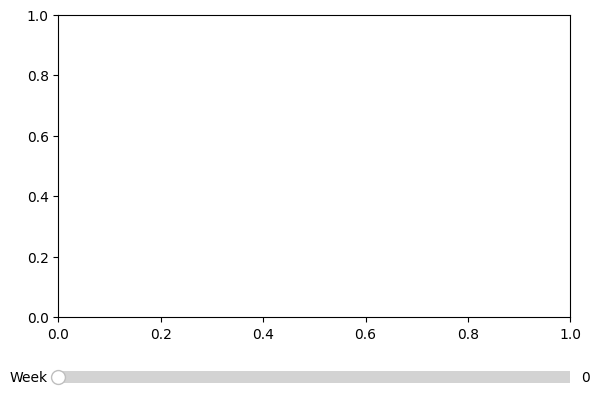

In [14]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd

# Constants for BC
# BC population in 2021:
num_nodes = 332
# 53 cities in BC
num_communities = 53
# Population density of BC cities
bc_population_density = [
    {"name": "Abbotsford", "population": 1535, "density": 2},
    {"name": "Armstrong", "population": 53, "density": 3},
    {"name": "Burnaby", "population": 2491, "density": 6},
    {"name": "Campbell River", "population": 355, "density": 1},
    {"name": "Castlegar", "population": 83, "density": 2},
    {"name": "Chilliwack", "population": 932, "density": 2},
    {"name": "Colwood", "population": 189, "density": 3},
    {"name": "Coquitlam", "population": 1486, "density": 3},
    {"name": "Courtenay", "population": 284, "density": 2},
    {"name": "Cranbrook", "population": 204, "density": 2},
    {"name": "Dawson Creek", "population": 123, "density": 2},
    {"name": "Delta", "population": 1084, "density": 2},
    {"name": "Duncan", "population": 50, "density": 5},
    {"name": "Enderby", "population": 30, "density": 2},
    {"name": "Fernie", "population": 63, "density": 2},
    {"name": "Fort St. John", "population": 214, "density": 2},
    {"name": "Grand Forks", "population": 41, "density": 2},
    {"name": "Greenwood", "population": 7, "density": 1},
    {"name": "Kamloops", "population": 97, "density": 2},
    {"name": "Kelowna", "population": 144, "density": 2},
    {"name": "Kimberley", "population": 8, "density": 1},
    {"name": "Langford", "population": 46, "density": 3},
    {"name": "Langley", "population": 289, "density": 6},
    {"name": "Maple Ridge", "population": 909, "density": 2},
    {"name": "Merritt", "population": 70, "density": 1},
    {"name": "Mission", "population": 415, "density": 1},
    {"name": "Nanaimo", "population": 998, "density": 3},
    {"name": "Nelson", "population": 111, "density": 3},
    {"name": "New Westminster", "population": 789, "density": 9},
    {"name": "North Vancouver", "population": 581, "density": 9},
    {"name": "Parksville", "population": 136, "density": 3},
    {"name": "Penticton", "population": 368, "density": 2},
    {"name": "Pitt Meadows", "population": 191, "density": 1},
    {"name": "Port Alberni", "population": 182, "density": 3},
    {"name": "Port Coquitlam", "population": 614, "density": 4},
    {"name": "Port Moody", "population": 335, "density": 3},
    {"name": "Powell River", "population": 139, "density": 2},
    {"name": "Prince George", "population": 767, "density": 1},
    {"name": "Prince Rupert", "population": 123, "density": 1},
    {"name": "Quesnel", "population": 98, "density": 1},
    {"name": "Revelstoke", "population": 82, "density": 1},
    {"name": "Richmond", "population": 2099, "density": 4},
    {"name": "Rossland", "population": 41, "density": 1},
    {"name": "Salmon Arm", "population": 194, "density": 1},
    {"name": "Surrey", "population": 5683, "density": 4},
    {"name": "Terrace", "population": 120, "density": 1},
    {"name": "Trail", "population": 79, "density": 1},
    {"name": "Vancouver", "population": 6622, "density": 11},
    {"name": "Vernon", "population": 445, "density": 2},
    {"name": "Victoria", "population": 918, "density": 9},
    {"name": "West Kelowna", "population": 360, "density": 1},
    {"name": "White Rock", "population": 219, "density": 8},
    {"name": "Williams Lake", "population": 109, "density": 2}
]

# COVID-19 Simulation Parameters
# Initial infection rate, recovery rate, mortality rate, incubation period, and mutation weeks
infection_rate = 0.15
recovery_rate = 0.9
mortality_rate = 0.01
incubation_period = 5
mutation_weeks = [48, 96]
mutation_rate = 1.2

# City-specific parameters
community_graphs = [
    nx.barabasi_albert_graph(
        each_city["population"],
        each_city["density"]) for each_city in bc_population_density]

# Combine regions into a single graph with inter-regional connections
G = nx.Graph()
offset = 0
for idx, community in enumerate(community_graphs):
    # Renumber nodes to prevent conflicts
    mapping = {node: node + offset for node in community.nodes}
    community = nx.relabel_nodes(community, mapping)
    G = nx.compose(G, community)
    offset += community.number_of_nodes()

    # Inter-region connections
    if idx < num_communities - 1:
        for _ in range(1145):
            node_a = random.choice(list(community.nodes))
            node_b = random.choice(
                list(community_graphs[idx + 1].nodes)) + offset
            G.add_edge(node_a, node_b)

# Initialize Infection Status
status = {node: 'S' for node in G.nodes}
initial_infected = random.sample(list(G.nodes), 20)  # Initial infections
for node in initial_infected:
    status[node] = 'E'

# Weekly Reporting
weekly_data = {'new_cases': [], 'cumulative_cases': [], 'deaths': []}
exposed_duration = {node: 0 for node in G.nodes}
cumulative_cases = len(initial_infected)


def simulate_week(status, exposed_duration):
    global infection_rate, cumulative_cases
    new_cases = 0
    deaths = 0

    for _ in range(7):  # Simulate 7 days per week
        new_status = status.copy()

        for node in G.nodes:
            if status[node] == 'E':
                exposed_duration[node] += 1
                if exposed_duration[node] >= incubation_period:
                    new_status[node] = 'I'
                    new_cases += 1

            elif status[node] == 'I':
                # Infect neighbors
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and random.random() < infection_rate:
                        new_status[neighbor] = 'E'

                # Death or Recovery
                if random.random() < mortality_rate:
                    new_status[node] = 'D'
                    deaths += 1
                elif random.random() < recovery_rate:
                    new_status[node] = 'R'

        status = new_status

    # Mutation Effect
    current_week = len(weekly_data['new_cases'])
    if current_week in mutation_weeks:
        infection_rate *= mutation_rate

    cumulative_cases += new_cases
    weekly_data['new_cases'].append(new_cases)
    weekly_data['cumulative_cases'].append(cumulative_cases)
    weekly_data['deaths'].append(deaths)

    return status


# Simulate 52 * 3 = 156 weeks (3 years)
weeks = 156
status_history = [status]
for week in range(weeks):
    status = simulate_week(status, exposed_duration)
    status_history.append(status)

# # Print Weekly Report
# print("Weekly Report:")
# for week in range(weeks):
#     print(f"Week {week + 1}: New Cases = {weekly_data['new_cases'][week]}, "
#           f"Cumulative Cases = {weekly_data['cumulative_cases'][week]}, "
#           f"Deaths = {weekly_data['deaths'][week]}")

# Convert weekly data to DataFrame for better display
weekly_df = pd.DataFrame({
    'Week': list(range(1, weeks + 1)),
    'New Cases': weekly_data['new_cases'],
    'Cumulative Cases': weekly_data['cumulative_cases'],
    'Deaths': weekly_data['deaths']
})


# Visualization Setup
def update():
    step = int(slider.val)
    current_status = status_history[step]
    color_map = {'S': 'blue', 'E': 'orange', 'I': 'red', 'R': 'green', 'D': 'black'}
    node_colors = [color_map[current_status[node]] for node in G.nodes]

    ax.clear()
    nx.draw(G, node_color=node_colors, with_labels=False,node_size=10, ax=ax,edge_color='none')
    ax.set_title(f"Week {step}")

    # Adding a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Susceptible'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Exposed'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Infected'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Recovered'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Dead')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

# Set up the figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.25)

# Create the slider
ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Week', 0, weeks, valinit=0, valstep=1)

# Update the plot when the slider value changes
slider.on_changed(update)

# Initial plot
update()

# Display the plot
plt.show()


# Graph is created based on the population of communities of vancouver

*   input: A specific day during the pandemic.
*   output: the map of vancouver communities colored according to the accumulative cases of the assigned day




In [13]:
import networkx as nx
import random
import pandas as pd
import folium
import geopandas as gpd
import branca

# Community sizes based on the provided population data
van_population_density = [
    {"name": "Arbutus-Ridge", "population": 16121, "density": 3},
    {"name": "Downtown", "population": 65380, "density": 12},
    {"name": "Dunbar-Southlands", "population": 22582, "density": 2},
    {"name": "Fairview", "population": 35435, "density": 7},
    {"name": "Grandview-Woodland", "population": 30750, "density": 5},
    {"name": "Hastings-Sunrise", "population": 36442, "density": 3},
    {"name": "Kensington-Cedar Cottage", "population": 51989, "density": 5},
    {"name": "Kerrisdale", "population": 14730, "density": 2},
    {"name": "Killarney", "population": 30909, "density": 3},
    {"name": "Kitsilano", "population": 45369, "density": 6},
    {"name": "Marpole", "population": 24460, "density": 3},
    {"name": "Mount Pleasant", "population": 34735, "density": 6},
    {"name": "Oakridge", "population": 13734, "density": 2},
    {"name": "Renfrew-Collingwood", "population": 54313, "density": 5},
    {"name": "Riley Park", "population": 23773, "density": 3},
    {"name": "Shaughnessy", "population": 8885, "density": 1},
    {"name": "South Cambie", "population": 8400, "density": 3},
    {"name": "Strathcona", "population": 13265, "density": 2},
    {"name": "Sunset", "population": 38471, "density": 4},
    {"name": "Victoria-Fraserview", "population": 32743, "density": 4},
    {"name": "West End", "population": 49749, "density": 17},
    {"name": "West Point Grey", "population": 13771, "density": 2}
]


# Initialize a dictionary to store node-community mappings
node_community_map = {}

# Generate a Barabási-Albert graph for each community based on its population size
community_graphs = [nx.barabasi_albert_graph(each_community['population'], each_community['density']) for each_community in van_population_density]

# Combine regions into a single graph with inter-regional connections
G = nx.Graph()
offset = 0
num_communities = len(community_graphs)
community_names = [community['name'] for community in van_population_density]

for idx, community in enumerate(community_graphs):
    community_name = community_names[idx]

    # Renumber nodes to prevent conflicts
    mapping = {node: node + offset for node in community.nodes}
    community = nx.relabel_nodes(community, mapping)

    # Update node-community mapping with the current community name
    for node in community.nodes:
        node_community_map[node] = community_name

    # Add the current community graph to the main graph
    G = nx.compose(G, community)
    offset += community.number_of_nodes()

    # Inter-region connections
    if idx < num_communities - 1:
        for _ in range(1145):  # Randomly connect 50 edges between regions
            node_a = random.choice(list(community.nodes))
            node_b = random.choice(list(community_graphs[idx + 1].nodes)) + offset
            G.add_edge(node_a, node_b)

# Initialize Infection Status
status = {node: 'S' for node in G.nodes}
initial_infected = random.sample(list(G.nodes), 20)  # Initial infections
for node in initial_infected:
    status[node] = 'E'

# COVID-19 Simulation Parameters
infection_rate = 0.15  # Initial infection rate
recovery_rate = 0.9
mortality_rate = 0.01
incubation_period = 5  # Days before symptoms
mutation_days = [336, 672]  # Days when virus mutates

# Daily Reporting
cumulative_cases = len(initial_infected)
exposed_duration = {node: 0 for node in G.nodes}
community_data = {name: {'cumulative_cases': 0} for name in community_names}

def simulate_day(status, exposed_duration):
    global infection_rate, cumulative_cases
    new_cases = 0

    # Temporary storage for today's cases by community
    community_daily_cases = {name: 0 for name in community_names}

    new_status = status.copy()

    for node in G.nodes:
        community_name = node_community_map[node]  # Get the community name for the current node

        if status[node] == 'E':
            exposed_duration[node] += 1
            if exposed_duration[node] >= incubation_period:
                new_status[node] = 'I'
                new_cases += 1
                community_daily_cases[community_name] += 1

        elif status[node] == 'I':
            # Infect neighbors
            for neighbor in G.neighbors(node):
                if status[neighbor] == 'S' and random.random() < infection_rate:
                    new_status[neighbor] = 'E'

            # Death or Recovery
            if random.random() < mortality_rate:
                new_status[node] = 'D'
            elif random.random() < recovery_rate:
                new_status[node] = 'R'

    # Update community-level cumulative cases
    for name in community_names:
        community_data[name]['cumulative_cases'] += community_daily_cases[name]

    # Mutation Effect
    current_day = len(exposed_duration)
    if current_day in mutation_days:
        infection_rate *= 1.2  # Increase infection rate by 20% for mutations

    cumulative_cases += new_cases

    return new_status

# Function to simulate up to a specified day
def simulate_until_day(target_day):
    global status
    for day in range(1, target_day + 1):
        status = simulate_day(status, exposed_duration)

    # Create a DataFrame with cumulative cases per community
    data = {
        'Community': [name for name in community_names],
        'Cumulative Cases': [community_data[name]['cumulative_cases'] for name in community_names]
    }
    df = pd.DataFrame(data)
    return df

# Example usage: Simulate until day 100 and get the report
day = 100  # Specify the day you want the report for
result_df = simulate_until_day(day)
print(f"COVID-19 Cumulative Report for Day {day}:\n")
print(result_df.to_string(index=False))

# transform dataframe to dictionary
cases_data = result_df.set_index('Community')['Cumulative Cases'].to_dict()

# import GeoJSON data
geojson_file = '../data/local-area-boundary.geojson'  # the path of geo file
gdf = gpd.read_file(geojson_file)

# create map
m = folium.Map(location=[49.26454048616976, -123.1310488653851], zoom_start=12)

# add headline of map
title_html = f'''
    <h3 align="center" style="font-size:20px"><b>COVID-19 accumulative cases - day {day} </b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# create color mapping, use the scope of accumulative cases
vmin = min(cases_data.values()) if cases_data else 0
vmax = max(cases_data.values()) if cases_data else 1
colormap = branca.colormap.LinearColormap(
    ['pink', 'red', 'purple'], vmin=vmin, vmax=vmax
).to_step(n=10)

# iterate GeoJSON data and add color to every region
for _, row in gdf.iterrows():
    # get geometry data of every region
    geom = row['geometry']
    region_name = row['name']  #  GeoJSON has "name" field to represent name of region

    # get the cases of this region
    cases = cases_data.get(region_name, 0)

    # set the filling color according to the number of cases
    color = colormap(cases)

    # add polygons
    folium.GeoJson(
        geom,
        style_function=lambda x, color=color: {
            'fillColor': color,  # filling
            'color': 'black',  # frame color
            'weight': 2,  # weidth
            'fillOpacity': 0.6  # transparency
        },
        tooltip=f"{region_name}: {cases}"  # the text of the mouse hovering
    ).add_to(m)

# add color legend
m.add_child(colormap)

# save map as HTML
m.save('map_with_cases.html')

# remind the user
print("the map has been saved as map_with_cases.html, open in a browser")


COVID-19 Cumulative Report for Day 100:

               Community  Cumulative Cases
           Arbutus-Ridge              5015
                Downtown             61454
       Dunbar-Southlands              2647
                Fairview             27596
      Grandview-Woodland             19086
        Hastings-Sunrise              7679
Kensington-Cedar Cottage               406
              Kerrisdale               255
               Killarney              8419
               Kitsilano             32744
                 Marpole              6969
          Mount Pleasant             11176
                Oakridge              1304
     Renfrew-Collingwood             33727
              Riley Park              6627
             Shaughnessy               198
            South Cambie              2722
              Strathcona               531
                  Sunset             18364
     Victoria-Fraserview             16258
                West End             48781
         West

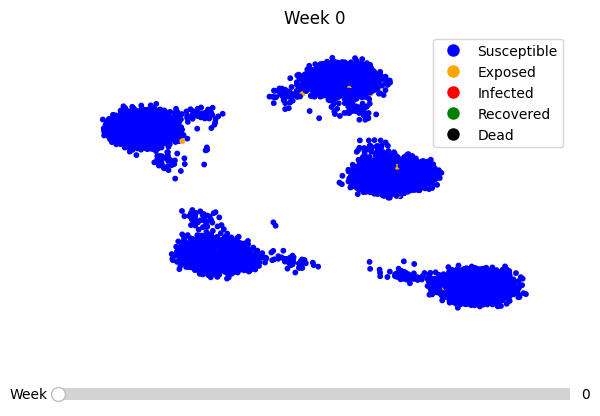

In [17]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd

# British Columbia Simulation Parameters
num_nodes = 5000  # Assume 500,000 individuals in the simulation
num_communities = 5  # 5 regions representing major BC cities

# City-specific parameters
community_sizes = [num_nodes // num_communities] * num_communities
community_graphs = [nx.barabasi_albert_graph(size, 4) for size in community_sizes]  # 4 connections per person

# Combine regions into a single graph with inter-regional connections
G = nx.Graph()
offset = 0
for idx, community in enumerate(community_graphs):
    # Renumber nodes to prevent conflicts
    mapping = {node: node + offset for node in community.nodes}
    community = nx.relabel_nodes(community, mapping)
    G = nx.compose(G, community)
    offset += community.number_of_nodes()

    # Inter-region connections
    if idx < num_communities - 1:
        for _ in range(50):  # Randomly connect 50 edges between regions
            node_a = random.choice(list(community.nodes))
            node_b = random.choice(list(community_graphs[idx + 1].nodes)) + offset
            G.add_edge(node_a, node_b)

# Initialize Infection Status
status = {node: 'S' for node in G.nodes}
initial_infected = random.sample(list(G.nodes), 20)  # Initial infections
for node in initial_infected:
    status[node] = 'E'

# COVID-19 Simulation Parameters
infection_rate = 0.15  # Initial infection rate
recovery_rate = 0.9
mortality_rate = 0.01
incubation_period = 5  # Days before symptoms
mutation_weeks = [48, 96]  # Weeks when virus mutates

# Weekly Reporting
weekly_data = {'new_cases': [], 'cumulative_cases': [], 'deaths': []}
exposed_duration = {node: 0 for node in G.nodes}
cumulative_cases = len(initial_infected)


def simulate_week(status, exposed_duration):
    global infection_rate, cumulative_cases
    new_cases = 0
    deaths = 0

    for _ in range(7):  # Simulate 7 days per week
        new_status = status.copy()

        for node in G.nodes:
            if status[node] == 'E':
                exposed_duration[node] += 1
                if exposed_duration[node] >= incubation_period:
                    new_status[node] = 'I'
                    new_cases += 1

            elif status[node] == 'I':
                # Infect neighbors
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and random.random() < infection_rate:
                        new_status[neighbor] = 'E'

                # Death or Recovery
                if random.random() < mortality_rate:
                    new_status[node] = 'D'
                    deaths += 1
                elif random.random() < recovery_rate:
                    new_status[node] = 'R'

        status = new_status

    # Mutation Effect
    current_week = len(weekly_data['new_cases'])
    if current_week in mutation_weeks:
        infection_rate *= 1.2  # Increase infection rate by 20% for mutations

    cumulative_cases += new_cases
    weekly_data['new_cases'].append(new_cases)
    weekly_data['cumulative_cases'].append(cumulative_cases)
    weekly_data['deaths'].append(deaths)

    return status


# Simulate over 12 weeks
weeks = 200
status_history = [status]
for week in range(weeks):
    status = simulate_week(status, exposed_duration)
    status_history.append(status)

# Convert weekly data to DataFrame for better display
weekly_df = pd.DataFrame({
    'Week': list(range(1, weeks + 1)),
    'New Cases': weekly_data['new_cases'],
    'Cumulative Cases': weekly_data['cumulative_cases'],
    'Deaths': weekly_data['deaths']
})


# Visualization Setup
def update():
    step = int(slider.val)
    current_status = status_history[step]
    color_map = {'S': 'blue', 'E': 'orange', 'I': 'red', 'R': 'green', 'D': 'black'}
    node_colors = [color_map[current_status[node]] for node in G.nodes]

    ax.clear()
    nx.draw(G, node_color=node_colors, with_labels=False,node_size=10, ax=ax,edge_color='none')
    ax.set_title(f"Week {step}")

    # Adding a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Susceptible'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Exposed'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Infected'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Recovered'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Dead')
    ]
    ax.legend(handles=legend_elements, loc='upper right')


# Set up the figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.25)

# Create the slider
ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Week', 0, weeks, valinit=0, valstep=1)

# Update the plot when the slider value changes
slider.on_changed(update)

# Initial plot
update()

# Display the plot
plt.show()
